In [ ]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset
from src.models.basicVae import LitBasicVae
import numpy as np
from src.dataset_classes.sequenceDataset import *
%load_ext autoreload
%autoreload 2

In [3]:
dataset = ProteinLigandInterfaceDataset(root='../data').to_point().torch()

In [4]:
# Initial testing to be done with proteins less than or equal to 150 residues in length
max_seq_length = dtu.get_max_seq_len(dataset)
seq_lengths = dtu.get_dataset_seq_lengths(dataset,leq = max_seq_length)
total_num = sum(seq_lengths.values())
total_num

4642

In [5]:
def ELBO(x, x_hat,x_mu, x_logvar):

    rec_loss =  torch.nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + x_logvar - x_mu.pow(2) - x_logvar.exp())

    return (rec_loss + KL_loss) / x.size(0) 

In [6]:
latent_dim = 256
epochs = 100
lr = 0.001
batch_size = 64
seq_test_data = SequenceDataset(dataset)
seq_dataloader = DataLoader(seq_test_data, batch_size=batch_size, shuffle=False)
x_dim = seq_test_data[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [95]:
model = BasicVae(latent_dim, x_dim, device).to(device)
model_optim = torch.optim.Adam(params=model.parameters(), lr=lr)

In [99]:
model.train()
train_loss = []

for epoch in range(epochs):
        batch_losses = []
        for batch_i, batch in enumerate(seq_dataloader):
                # forward pass
                x = batch[0].view(-1, x_dim).to(device)
                rep_z, x_mu, x_logvar, x_rec = model(x)
                loss = ELBO(x, x_rec,x_mu, x_logvar)
                batch_losses.append(loss.data.cpu().item())
                
                model_optim.zero_grad()
                loss.backward()
                model_optim.step()
        train_loss.append(sum(batch_losses)/len(batch_losses))
        print(f"Epoch {epoch} Loss: {train_loss[-1]}")

Epoch 0 Loss: 8805.857168537297
Epoch 1 Loss: 573.4133238073898
Epoch 2 Loss: 486.7336163455493
Epoch 3 Loss: 448.12906897557923
Epoch 4 Loss: 427.8821528186537
Epoch 5 Loss: 425.5512349899501
Epoch 6 Loss: 1031.3734661781625
Epoch 7 Loss: 448.97540769185105
Epoch 8 Loss: 407.24881456976067
Epoch 9 Loss: 514.6150695591757
Epoch 10 Loss: 382.69239195732223
Epoch 11 Loss: 367.11851961318763
Epoch 12 Loss: 368.1743119644792
Epoch 13 Loss: 353.2147185443199
Epoch 14 Loss: 339.25786250911347
Epoch 15 Loss: 376.5941721249933
Epoch 16 Loss: 332.3824231918544
Epoch 17 Loss: 336.3386949513056
Epoch 18 Loss: 298.5822531817711
Epoch 19 Loss: 282.57972617998513
Epoch 20 Loss: 281.8378340838707
Epoch 21 Loss: 360.15298825094146
Epoch 22 Loss: 2382.794402396842
Epoch 23 Loss: 542.9460882422043
Epoch 24 Loss: 308.50129427975173
Epoch 25 Loss: 277.3441021017832
Epoch 26 Loss: 264.69404899910705
Epoch 27 Loss: 258.6429685827804
Epoch 28 Loss: 244.99498798422619
Epoch 29 Loss: 245.98766264196945
Epoch 3

In [7]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=100,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
model = LitBasicVae(latent_dim, x_dim)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, seq_dataloader)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name           | Type    | Params | Mode 
---------------------------------------------------
0 | relu           | ReLU    | 0      | train
1 | sig            | Sigmoid | 0      | train
2 | fc1_enc        | Linear  | 47.5 M | train
3 | fc3_enc_mean   | Linear  | 131 K  | train
4 | fc3_enc_logvar | Linear  | 131 K  | train
5 | fc1_dec        | Linear  | 131 K  | train
6 | fc3_dec        | Linear  | 47.6 M | train
---------------------------------------------------
95.5 M    Trainable params
0         Non-trainable params
95.5 M    Total params
381.895   Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
labels = []
latent_coord = []
model.eval()
for batch_i, batch in enumerate(seq_dataloader):
    # labels.append(batch[1].to('cpu').numpy())
    # x = batch[0].view(-1, x_dim).to(device)
    rep_z, x_mu, x_logvar, x_rec = model(batch)
    latent_coord.append(x_mu.to('cpu').detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [10]:
latent_coord

array([[ 0.01262472, -0.09809753, -0.07252724, ...,  0.23386571,
         0.12038825, -0.03749418],
       [ 0.0594572 , -0.07933982,  0.10178749, ...,  0.09996183,
         0.05545003,  0.08433231],
       [ 0.05212124, -0.0873745 ,  0.11193117, ...,  0.08873858,
         0.05037044,  0.08979265],
       ...,
       [ 0.06819684, -0.09151234,  0.09668663, ...,  0.07079172,
         0.07146735,  0.10889755],
       [ 0.06006777, -0.06574208,  0.09153965, ...,  0.09668906,
         0.08513398,  0.07984908],
       [ 0.06383976, -0.0957931 ,  0.10219815, ...,  0.0702812 ,
         0.0666408 ,  0.10546778]], dtype=float32)

In [11]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

In [12]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 

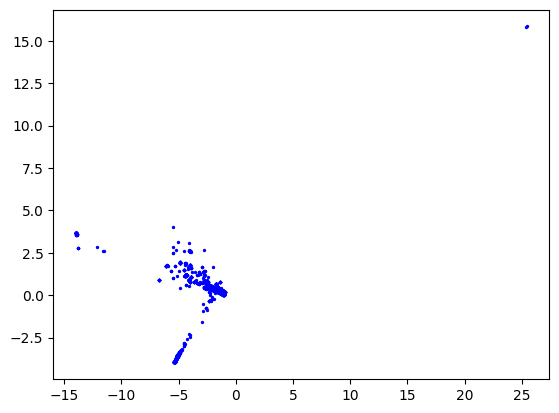

In [13]:
import matplotlib.pyplot as plt
plt.scatter(projected_data.numpy()[:, 0], projected_data.numpy()[:, 1], s = 2, color = 'b')